In [2]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.datasets import mnist
import numpy as np
import tensorflow.keras as K
from tensorflow.keras.regularizers import l2
# from resnet import ResNet
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import pandas as pd
# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

# from google.colab import files
  
  
# uploaded = files.upload()

In [4]:
def load_az(path):
    labels = []
    data = []
#     print(path)
    
    for row in open(datasetPath):
		row = row.split(",")
		label = int(row[0])
		image = np.array([int(x) for x in row[1:]], dtype="uint8")
		image = image.reshape((28, 28))
		data.append(image)
		labels.append(label)
    # df = pd.read_csv(path)
#     print(df)
    # for i in df.iloc[:,1:].iterrows():
    #     image = np.array(list(i), dtype = "uint8")
    #     data.append(image.reshape((28,28)))

    data = np.array(data, dtype = "float32")
    labels = np.array(df.iloc[:,0], dtype = "int")
    
    return (data, labels)

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import build_montages
import io
def load_09():
    ((trainData, trainLabel),(testData, testLabel)) = mnist.load_data()
    data = np.vstack([trainData, testData])
    labels = np.hstack([trainLabel, testLabel])
    
    return (data, labels)
(data09, label09) = load_09()
# (dataAz, labelAz) = load_az(io.BytesIO(uploaded['A_Z_data.csv']))
(dataAz, labelAz) = load_az('A_Z_data.csv')
labelAz += 10

data = np.vstack([data09, dataAz])
label = np.hstack([label09, labelAz])

# data = data09
# label = label09
# pixel intensities of the images from [0, 255] down to [0, 1]
data = np.expand_dims(data, axis=-1)
# data /= 255.0
data = np.divide(data,255.0)
# (label,data)

In [11]:
# convert the labels from integers to vectors
le = LabelBinarizer()
label = le.fit_transform(label)
totalClass = label.sum(axis=0)
classWeight = {}

# loop over all classes and calculate the class weight
for i in range(0, len(totalClass)):
    classWeight[i] = totalClass.max() / totalClass[i]
    
(trainX, testX, trainY, testY) = train_test_split(data, label, test_size = 0.3, stratify=label, random_state=42)

# Augmentation

aug = ImageDataGenerator(
    rotation_range = 10,
    zoom_range = 0.05,
    width_shift_range = 0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    fill_mode="nearest"
)


In [14]:
# from resnet import build
# import resnet
epoch = 50
alpha = 1e-1
batchSize = 128

print(trainX.shape)
# rgb_trainX = np.repeat(trainX[..., np.newaxis], 3, -1)
# rgb_testX = np.repeat(testX[..., np.newaxis], 3, -1)
# print(rgb_trainX.shape)

print("[INFO] compiling model...")
opt = SGD(lr = alpha, decay = alpha/epoch)


input_t = K.Input(shape = (32,32,1))
res_model = K.applications.ResNet50(include_top = False,
                                weights = "imagenet"
                               )
model = K.models.Sequential()
model.add(keras.layers.Conv2D(3,(3,3),padding = 'same',input_shape=(32,32,1)))
model.add(res_model)
model.add(K.layers.Flatten())
model.add(K.layers.Dense(len(le.classes_), kernel_regularizer=l2(0.0001), activation = 'softmax'))

# model = ResNet.build(32, 32, 1, len(le.classes_), (3, 3, 3),(64, 64, 128, 256), reg=0.0005)
check_point = K.callbacks.ModelCheckpoint(filepath = "resNet50.h5",
                                         monitor = "val_acc",
                                         mode = "max",
                                         save_best_only = True)
model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])
# model.build()
model.summary()


(49000, 28, 28, 1)
[INFO] compiling model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 3)         30        
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                20490     
Total params: 23,608,232
Trainable params: 23,555,112
Non-trainable params: 53,120
_________________________________________________________________


In [16]:
history = model.fit(aug.flow(trainX, trainY, batch_size = batchSize),
                   validation_data = (testX, testY),
                   steps_per_epoch = len(trainX)/batchSize,
                   epochs = epoch,
                   class_weight = classWeight,
                   verbose = 1
                   )

# labelNames = "0123456789"
labelNames = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]

#model evaluation
pred = model.predict(testX, batch_size = batchSize)
print(classification_report(testY.argmax(axis = 1),
                           pred.argmax(axis = 1),
                           target_names = labelNames))
model.save("resNet50.h5")

Epoch 1/50
382/382 [==============================] - 40s 105ms/step - loss: 0.0426 - accuracy: 0.9887 - val_loss: 0.0271 - val_accuracy: 0.9924
Epoch 2/50
382/382 [==============================] - 40s 105ms/step - loss: 0.0375 - accuracy: 0.9901 - val_loss: 0.0262 - val_accuracy: 0.9930
Epoch 3/50
382/382 [==============================] - 40s 105ms/step - loss: 0.0330 - accuracy: 0.9915 - val_loss: 0.0246 - val_accuracy: 0.9933
Epoch 4/50
382/382 [==============================] - 40s 105ms/step - loss: 0.0285 - accuracy: 0.9924 - val_loss: 0.0245 - val_accuracy: 0.9931
Epoch 5/50
382/382 [==============================] - 40s 105ms/step - loss: 0.0266 - accuracy: 0.9930 - val_loss: 0.0252 - val_accuracy: 0.9932
Epoch 6/50
382/382 [==============================] - 40s 105ms/step - loss: 0.0249 - accuracy: 0.9937 - val_loss: 0.0246 - val_accuracy: 0.9933
Epoch 7/50
382/382 [==============================] - 40s 105ms/step - loss: 0.0239 - accuracy: 0.9937 - val_loss: 0.0232 - val_ac

In [ ]:
# from tensorflow.keras import backend as K
# K.tensorflow_backend._get_available_gpus()

import tensorflow as tf
tf.test.is_built_with_cuda()
print(tf.__version__)
# print(tf.keras.__version__)
# print(tf.config.list_physical_devices('GPU'))
# print(tf.config.list_physical_devices('CPU'))
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

2.2.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [19]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
from google.colab import files


N = np.arange(0, epoch)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("acc.png")
files.download('acc.png')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

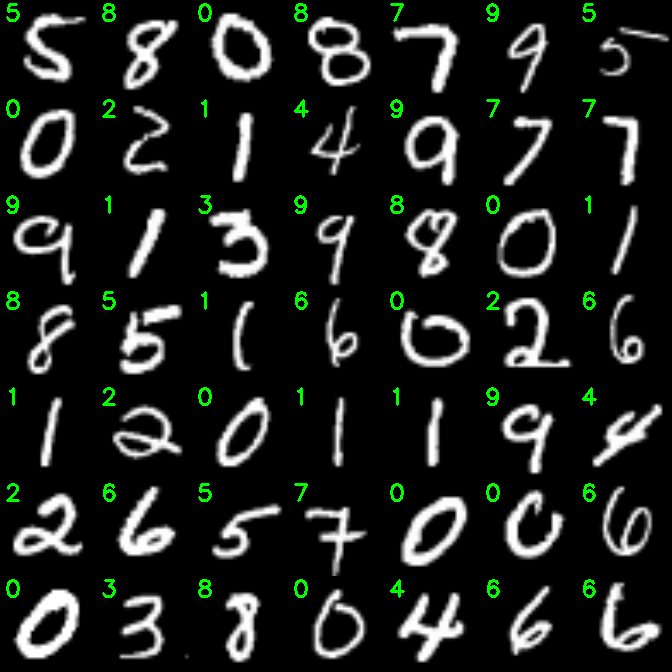

In [33]:
from google.colab.patches import cv2_imshow
from IPython.display import Image

# initialize our list of output test images
images = []
# randomly select a few testing characters
for i in np.random.choice(np.arange(0, len(testY)), size=(49,)):
	# classify the character
	probs = model.predict(testX[np.newaxis, i])
	prediction = probs.argmax(axis=1)
	label = labelNames[prediction[0]]
	# extract the image from the test data and initialize the text
	# label color as green (correct)
	image = (testX[i] * 255).astype("uint8")
	color = (0, 255, 0)
	# otherwise, the class label prediction is incorrect
	if prediction[0] != np.argmax(testY[i]):
		color = (0, 0, 255)
	# merge the channels into one image, resize the image from 32x32
	# to 96x96 so we can better see it and then draw the predicted
	# label on the image
	image = cv2.merge([image] * 3)
	image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
	cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
		color, 2)
	# add the image to our list of output images
	images.append(image)
# construct the montage for the images
montage = build_montages(images, (96, 96), (7, 7))[0]

cv2.imwrite("Output.png", montage)
from IPython.display import Image
Image(filename="Output.png")